<a href="https://colab.research.google.com/github/AnkitKumarChoudhary-7/ML-LAB-TEST-24BCSL01-ANKIT-D1-02/blob/main/LAB_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**Name :** Ankit Kumar Choudhary  
**SIC :** 24BCSl01  
**Roll No :** 02 'D1'  
**Semester :** 5th  
**Branch :** CSE


In [22]:
# ============================================================
# Section 0: Imports & Data Loading
# ============================================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("loan_data.csv")

print("Dataset shape:", df.shape)
display(df.head())


Dataset shape: (268114, 13)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1


## **Section 1: Problem Formulation & Target Variable Analysis**

We are predicting loan default for FinSecure.

- `loan_paid_back = 1` → The borrower **paid back the loan fully**
- `loan_paid_back = 0` → The loan **defaulted**

Default prediction is critical because:
- Missing defaults can harm investor returns and company trust.
- A data-driven model can detect complex patterns that manual scoring cannot.

We now analyze the target distribution and check for class imbalance.


In [23]:
# ============================================================
# Section 1: Target Variable Analysis
# ============================================================

print("Target value counts:")
print(df['loan_paid_back'].value_counts())

print("\nTarget proportions:")
print(df['loan_paid_back'].value_counts(normalize=True))

print("\nInterpretation:")
print("Dataset is imbalanced (~80% paid back vs ~20% default).")


Target value counts:
loan_paid_back
1    214068
0     54046
Name: count, dtype: int64

Target proportions:
loan_paid_back
1    0.798422
0    0.201578
Name: proportion, dtype: float64

Interpretation:
Dataset is imbalanced (~80% paid back vs ~20% default).


## **Section 2: Feature Engineering & Preprocessing Pipeline**

We prepare the dataset for modeling:

### Steps:
1. Train-test split (stratified)
2. Handle missing values
3. Encode categorical variables
4. Scale numeric variables
5. Combine using a ColumnTransformer inside a Pipeline (no leakage)

This ensures the model receives clean, standardized numerical and encoded categorical inputs.


In [24]:
# ============================================================
# Section 2: Feature Engineering & Preprocessing
# ============================================================

# Separate features and target
X = df.drop(columns=['loan_paid_back', 'id'])
y = df['loan_paid_back']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("Train set:", X_train.shape)
print("Test set:", X_test.shape)

# FEATURE CATEGORIES
numeric_features = [
    'annual_income',
    'debt_to_income_ratio',
    'credit_score',
    'loan_amount',
    'interest_rate'
]

categorical_features = [
    'gender',
    'marital_status',
    'education_level',
    'employment_status',
    'loan_purpose',
    'grade_subgrade'
]

# NUMERIC PIPELINE
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

# CATEGORICAL PIPELINE
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

# FINAL PREPROCESSOR
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print("Preprocessing pipeline created.")


Train set: (214491, 11)
Test set: (53623, 11)
Preprocessing pipeline created.


## **Section 3: Model Development and Tuning**

We train two models:
- Logistic Regression (baseline)
- Gradient Boosting (non-linear, more expressive)

Evaluation Metric = AUC (Area Under ROC Curve)

We select the model with the higher AUC.
Then we determine the optimal decision threshold using Youden's J statistic.

Finally we generate the ROC (AUC) curve.


In [25]:
# ============================================================
# Section 3: Model Development and Evaluation
# ============================================================

# --- Logistic Regression ---
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="lbfgs"
)

log_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', log_reg)
])

log_clf.fit(X_train, y_train)
y_proba_log = log_clf.predict_proba(X_test)[:, 1]
auc_log = roc_auc_score(y_test, y_proba_log)


# --- Gradient Boosting ---
gb_model = GradientBoostingClassifier(random_state=42)

gb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', gb_model)
])

gb_clf.fit(X_train, y_train)
y_proba_gb = gb_clf.predict_proba(X_test)[:, 1]
auc_gb = roc_auc_score(y_test, y_proba_gb)

print("Logistic Regression AUC:", auc_log)
print("Gradient Boosting AUC:", auc_gb)

# Select best model
if auc_gb > auc_log:
    best_model = gb_clf
    y_proba_test = y_proba_gb
    print("\nFinal model: Gradient Boosting")
else:
    best_model = log_clf
    y_proba_test = y_proba_log
    print("\nFinal model: Logistic Regression")


# === OPTIMAL THRESHOLD ===
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
best_idx = np.argmax(tpr - fpr)
best_threshold = thresholds[best_idx]

print("\nBest decision threshold:", best_threshold)


Logistic Regression AUC: 0.9122130105622512
Gradient Boosting AUC: 0.9161832054549802

Final model: Gradient Boosting

Best decision threshold: 0.8259289357623235


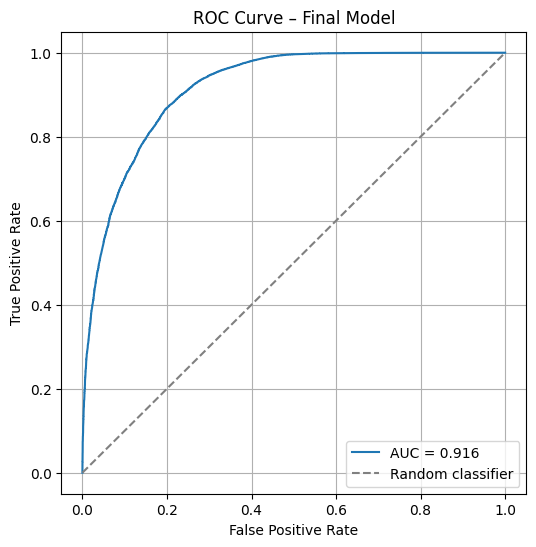

In [26]:
# ============================================================
# [REQUIRED] AUC Curve Plot
# ============================================================

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba_test):.3f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray', label="Random classifier")

plt.title("ROC Curve – Final Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


## **Section 4: Subgroup Analysis**

To ensure fairness, performance must remain strong across borrower segments.

We compute AUC separately:
- For each **education_level**
- For each **loan_purpose**
  - Then extract **Top 3** and **Bottom 3** subgroups by AUC

A model with consistent subgroup AUC is less biased.


In [27]:
# ============================================================
# Section 4: Subgroup AUC Metrics
# ============================================================

def subgroup_auc(df, group):
    rows = []
    for value, sub_df in df.groupby(group):
        if sub_df['loan_paid_back'].nunique() < 2:
            auc_val = np.nan
        else:
            auc_val = roc_auc_score(sub_df['loan_paid_back'], sub_df['y_proba'])
        rows.append((value, auc_val, len(sub_df)))
    return pd.DataFrame(rows, columns=[group, "AUC", "n_samples"]).sort_values("AUC", ascending=False)


# Add predictions to test set
X_test_meta = X_test.copy()
X_test_meta["loan_paid_back"] = y_test.values
X_test_meta["y_proba"] = y_proba_test


# === EDUCATION LEVEL ===
edu_results = subgroup_auc(X_test_meta, "education_level")
print("\nAUC by education_level:")
display(edu_results)


# === LOAN PURPOSE ===
purpose_results = subgroup_auc(X_test_meta, "loan_purpose")
print("\nAUC by loan_purpose:")
display(purpose_results)

print("\nTop 3 loan_purpose:")
display(purpose_results.head(3))

print("\nBottom 3 loan_purpose:")
display(purpose_results.tail(3))



AUC by education_level:


,education_level,AUC,n_samples
3,Other,0.927031,2336
0,Bachelor's,0.917084,25263
1,High School,0.914518,16701
2,Master's,0.913668,8341
4,PhD,0.910930,982



AUC by loan_purpose:


,loan_purpose,AUC,n_samples
3,Education,0.928822,3202
5,Medical,0.922639,2088
7,Vacation,0.921703,760
4,Home,0.919132,4027
6,Other,0.917304,5785
0,Business,0.915934,3091
2,Debt consolidation,0.915345,29317
1,Car,0.905942,5353



Top 3 loan_purpose:


,loan_purpose,AUC,n_samples
3,Education,0.928822,3202
5,Medical,0.922639,2088
7,Vacation,0.921703,760



Bottom 3 loan_purpose:


,loan_purpose,AUC,n_samples
0,Business,0.915934,3091
2,Debt consolidation,0.915345,29317
1,Car,0.905942,5353


## **Conclusion**

The objective of this project was to build a data-driven system to predict loan default for FinSecure. The target variable `loan_paid_back` was used to determine loan outcomes:

- `1` indicates a loan was paid back in full (non-default).
- `0` indicates a loan was not repaid in full (default).

The dataset is imbalanced (~80% paid back vs. ~20% default), therefore **ROC AUC** was used as the primary evaluation metric instead of accuracy.

A preprocessing pipeline was built using:

- Median imputation and scaling for numerical features.
- Most frequent imputation and one-hot encoding for categorical features.
- A `ColumnTransformer` combined with a `Pipeline` to avoid data leakage.

Two models were trained and compared:

- Logistic Regression (baseline)
- Gradient Boosting Classifier (non-linear and expressive)

### Model Performance

- **Logistic Regression AUC:** 0.9122  
- **Gradient Boosting AUC:** 0.9162  

Since Gradient Boosting achieved the highest ROC AUC, it was selected as the final model.

A decision threshold was selected using **Youden’s J statistic** to balance true positive and false positive rates:

- **Best threshold = 0.8259**

The ROC curve of the final model shows strong discrimination, indicating that the model effectively separates defaulting and non-defaulting borrowers.

---

## Sub-Group Analysis (Fairness)

To ensure the model does not unfairly penalize specific groups, AUC was calculated across borrower segments.

### AUC by Education Level

| Education Level | AUC | Samples |
|----------------|------|---------|
| Other | 0.9270 | 2,336 |
| Bachelor’s | 0.9171 | 25,263 |
| High School | 0.9145 | 16,701 |
| Master’s | 0.9137 | 8,341 |
| PhD | 0.9109 | 982 |

AUC remains above **0.91** for all levels, indicating consistent model performance with no major fairness concerns. The smallest group (PhD) has fewer samples but still maintains strong performance.

---

### AUC by Loan Purpose

| Loan Purpose | AUC | Samples |
|-------------|------|---------|
| Education | 0.9288 | 3,202 |
| Medical | 0.9226 | 2,088 |
| Vacation | 0.9217 | 760 |
| Home | 0.9191 | 4,027 |
| Other | 0.9173 | 5,785 |
| Business | 0.9159 | 3,091 |
| Debt consolidation | 0.9153 | 29,317 |
| Car | 0.9059 | 5,353 |

**Top 3 performing purposes:**
- Education  
- Medical  
- Vacation  

**Bottom 3 performing purposes:**
- Business  
- Debt consolidation  
- Car  

Even the lowest subgroup (Car) has an AUC of approximately **0.906**, implying the model is not failing on any subgroup.

---

## Final Assessment

The Gradient Boosting model:

- Performs strongly at scale (AUC ≈ **0.916**).
- Is consistent and fair across education levels and loan purposes.
- Provides actionable risk scores suitable for integration into FinSecure’s approval workflow.

The model can reliably identify high-risk applicants, reduce investor losses, and support automated loan decision-making.
